# Calculating state average of a variable and plotting using shape file

#######PYTHON CODE FOR IMD PREPARED BY LEKSHMI S#############

########## https://doi.org/10.5281/zenodo.5674826 ############

In [1]:
#################Import necessary Modules####################
import geopandas as gpd
import regionmask 
import numpy as np
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import xarray as xr
import netCDF4 as nc

/root/anaconda3/envs/pyn_env/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
############### Read the data file###########################
file_name ='/mnt/d/DATA/ERA5/Wind/ERA5_Wind_2019.nc'
f = xr.open_dataset(file_name)
u10=f.u10.values
lat=f.latitude.values
lon=f.longitude.values
lat_size=len(lat)
lon_size=len(lon)

In [3]:
################Read the shape file##########################
fname='/mnt/e/Python_DEMO_Scripts/plotting/shpfile/Admin2.shp'
shp=gpd.read_file(fname)
#print(shp.head())

state_name=list(shp['ST_NM'])
state_1=list(shp['ST_NM'])
indexes=[state_name.index(x) for x in state_1]		# Obtain state indexes

state1=regionmask.Regions(outlines=list(shp.geometry.values[i] for i in range(0, shp.shape[0])), names=shp.ST_NM[indexes],abbrevs=shp.ST_NM[indexes],name='state', )	##Obtaining region boundaries
state1_mask=state1.mask(lon,lat)			##### State mask variable

In [4]:
###################Calculating first state average################
time_ind=10						####Any time step as per need
u10_all=np.full([lat_size,lon_size],np.nan,order='C')	##Create a variable to store state averagein whole lat-lon range
result=np.where(state1_mask==0)			###Obtain indices for first state
lat_ind=result[0]					# latitude index for state1
lon_ind=result[1]					# longitude index for state1
u10_state=np.mean((u10[time_ind,:,:][lat_ind,:][:,lon_ind]),axis=(0,1))##Calculate state mean (single value)
u10_all[result]=u10_state				##Store state mean in the whole lat-lon range
del u10_state						# delete variables for future use
del result
del lat_ind
del lon_ind

/root/anaconda3/envs/pyn_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/root/anaconda3/envs/pyn_env/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Text(449.79340964108684, 0.5, 'Lat')

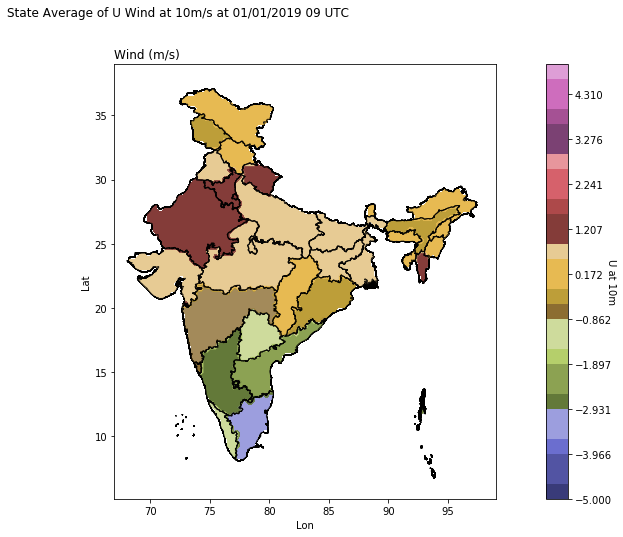

In [5]:
#####################Plotting Settings#############################
###############Plotting state 1 average############################
lev_min=-5                      #Setting contour min,max levels and divisions
lev_max=5
lev_n=30
plt.figure(figsize=(18,8))      # Plot settings
ax=plt.axes()
x,y=np.meshgrid(lon,lat)
c=ax.contourf(x,y,u10_all,cmap='tab20b',levels=np.linspace(lev_min,lev_max,lev_n))	#Contour plot
shp.plot(ax=ax,alpha=0.8,facecolor='None',lw=1) # Shape file plot

##################Calculating and plotting remaining state average in a loop##############
for i in range(1,shp.shape[0]):          ## Remaining states in a loop
	result=np.where(state1_mask==i)
	lat_ind=result[0]
	lon_ind=result[1]
	u10_state=np.mean((u10[time_ind,:,:][lat_ind,:][:,lon_ind]),axis=(0,1))
	u10_all[result]=u10_state
	del u10_state
	
	ax.contourf(x,y,u10_all,cmap='tab20b',alpha=0.8,levels=np.linspace(lev_min,lev_max,lev_n))
	shp.plot(ax=ax,alpha=0.8,facecolor='None',lw=1)
	
cbar=plt.colorbar(c)                            ## Give colorbar
cbar.set_label('U at 10m', rotation=270)        ##Colorbar label
plt.suptitle('State Average of U Wind at 10m/s at 01/01/2019 09 UTC')
plt.title('Wind (m/s)', loc='left')
plt.xlabel('Lon')
plt.ylabel('Lat')